<a href="https://colab.research.google.com/github/chandu8542/codemix/blob/main/sarc_self_match_bi_LSTM_fastext_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import wget
import os
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

In [4]:
def get_max_len(tweets):
    max_tweet_len = len(max(tweets, key=len).split())
    return max_tweet_len

In [5]:
def get_mean_len(tweets):
    sum_of_length = sum([len(l.split()) for l in tweets])
    avg_tweet_len = sum_of_length / float(len(tweets))
    return avg_tweet_len

In [6]:
datapath = "/home/ckm/ck_project/data/sarcasm/"
df_embedding = pd.read_csv(datapath+'hing_emb', sep=" ", quoting=3, header=None, index_col=0,skiprows=1)

**LexVec Word Embedding**

In [7]:
embedding_matrix = df_embedding.to_numpy()

**Extracting Vocabulary from word embedding**

In [8]:
vocab = []

for word in list(df_embedding.index):
  vocab.append(str(word))

In [9]:
vocab_size , vocab_dim = embedding_matrix.shape
vocab_size, vocab_dim

(44050, 100)

**Reading the data**


In [10]:

traindata = pd.read_csv( datapath+"train.csv",sep=',')
testdata = pd.read_csv(datapath+ "test.csv",sep=',')
validdata = pd.read_csv(datapath+"valid.csv",sep=',')

In [11]:
print(traindata.shape)
print(testdata.shape)
print(validdata.shape)

(115000, 3)
(30000, 3)
(21370, 3)


In [12]:
X_train_data = traindata['tweets']
y_train_labels = traindata['labels']
X_test_data = testdata['tweets']
y_test_labels = testdata['labels']
X_valid_data = validdata['tweets']
y_valid_labels  = validdata['labels']

In [13]:
y_test_labels

0        0
1        1
2        0
3        0
4        1
        ..
29995    1
29996    0
29997    0
29998    1
29999    0
Name: labels, Length: 30000, dtype: int64

In [14]:
max_input_length = get_max_len(X_train_data)
mean_input_length = get_mean_len(X_train_data)
max_input_length, int(mean_input_length)



(65, 17)

**Tokenization**

In [15]:
tokenizer = Tokenizer(num_words= vocab_size)
tokenizer.fit_on_texts(vocab)

maxlen = max_input_length

# tokenizing training data
sequences_train = tokenizer.texts_to_sequences(X_train_data)
X_train_data = pad_sequences(sequences_train, maxlen=maxlen,padding='post',truncating='post')

# # tokenizing test data
sequences_test = tokenizer.texts_to_sequences(X_test_data)
X_test_data = pad_sequences(sequences_test, maxlen=maxlen,padding='post',truncating='post')

# tokenize the validation data
sequences_valid = tokenizer.texts_to_sequences(X_valid_data)
X_valid_data = pad_sequences(sequences_valid, maxlen=maxlen,padding='post',truncating='post')


In [61]:
print(sequences_train[0])
print(X_train_data[0])
tokenizer.sequences_to_texts([sequences_train[0]])

[1431, 9106, 16, 26, 35, 16, 16, 12, 196]
[1431 9106   16   26   35   16   16   12  196    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


['general secretary of ghar on of of in his']

In [62]:
checkpoint_path = "/content/drive/MyDrive/models/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [63]:
'''class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    try:
      if(logs.get('accuracy')>0.979):
        self.model.stop_training = True
    except:
      if(logs.get('acc')>0.979):
        self.model.stop_training = True


acc_callback = myCallback()
early_stopping_callback = tf.keras.callbacks.EarlyStopping()
'''

def scheduler(epoch, lr):
  if epoch < 5:
    print("Learning rate", lr)
    return lr
  else:
    lr = lr * tf.math.exp(-0.1)
    print("Epoch: {} Learning rate: {}", epoch, lr)
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [64]:
class SelfMatchingLayer(tf.keras.layers.Layer):
    def __init__(self,  seq_length, embed_dim, **kwargs):
      self.seq_length = seq_length
      self.embed_dim  = embed_dim
      self.output_dim = seq_length*embed_dim # dim of the paramter W
      super(SelfMatchingLayer, self).__init__(**kwargs)

    def build(self, input_shape): # input_shape is the shape of x
      self.M = self.add_weight(name='M', # M is square matrix of shape n*k X n*k , see the paper selfmatching network
                                      shape=tf.TensorShape((self.output_dim, self.output_dim )).as_list(),
                                      initializer='glorot_uniform',
                                      trainable=True)
      super(SelfMatchingLayer, self).build(input_shape)  # Be sure to call this at the end
      
    def call(self,x):
      # print(K.int_shape(x))
      # create an identity matrix of shape seq_length
      t = tf.eye(self.seq_length, dtype=x.dtype) 
      # Add one dimension to x and one dimension to t
      xt = tf.expand_dims(x, 1) * tf.expand_dims(t, 2)
      # Reshape, output is basically a diagnoal magtrix whose entries are embeddings
      output = tf.reshape(xt, (-1, self.seq_length, self.output_dim))
      # E*M*E^T happens bellow
      tmp = tf.matmul(output, self.M)
      result = tf.matmul(tmp,output, transpose_b=True)
      # maximize by rows
      result = tf.reduce_max(result, axis=-1)
      # take softmax
      result = tf.nn.softmax(result)
      result = tf.einsum('ij,ijk->ik',result,x)
      return result
    def compute_output_shape(input_shape):
      return (input_shape[0], self.output_dim)

In [65]:
input_layer = tf.keras.Input(shape=(maxlen, ),name='text_input')
input_embedding_layer = tf.keras.layers.Embedding(vocab_size, vocab_dim,
                        embeddings_initializer=Constant(embedding_matrix), 
                        trainable = False)
bi_lstm_layer = layers.Bidirectional(layers.LSTM(100, dropout=0.4,
                        recurrent_dropout=0))
selfmatching_layer = SelfMatchingLayer(maxlen,vocab_dim, name='selfmatch')

In [66]:
embedding_output = input_embedding_layer(input_layer)

selfmatch_output = selfmatching_layer(embedding_output)
bi_lstm_output = bi_lstm_layer(embedding_output)

concat_features = tf.concat([selfmatch_output, bi_lstm_output],-1)
sarc_prediction = layers.Dense(64,activation='relu',name='activation_relu')(concat_features)
sarc_prediction = layers.Dense(2,activation='softmax',name='activation_softmax')(sarc_prediction)
#sarc_prediction = layers.Softmax()(sarc_prediction)

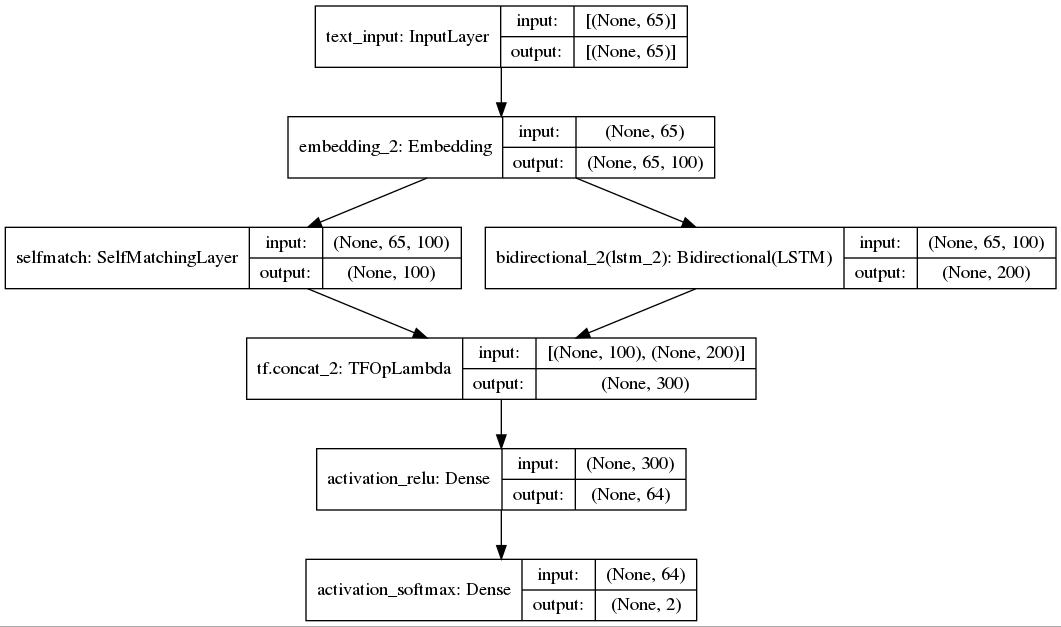

In [67]:
model = tf.keras.Model(input_layer, sarc_prediction)
tf.keras.utils.plot_model(model,'model.jpg',show_shapes=True)

In [68]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 65, 100)      4405000     text_input[0][0]                 
__________________________________________________________________________________________________
selfmatch (SelfMatchingLayer)   (None, 100)          42250000    embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200)          160800      embedding_2[0][0]                
____________________________________________________________________________________________

In [69]:
history = model.fit(np.array(X_train_data), np.array(y_train_labels), validation_data=(np.array(X_valid_data), np.array(y_valid_labels)), epochs=20, callbacks= [callback]) 

Epoch 1/20
Learning rate 0.0010000000474974513
3594/3594 [==============================] - 1272s 353ms/step - loss: 0.5416 - accuracy: 0.7337 - val_loss: 0.4360 - val_accuracy: 0.8149
Epoch 2/20
Learning rate 0.0010000000474974513
3594/3594 [==============================] - 1265s 352ms/step - loss: 0.4252 - accuracy: 0.8259 - val_loss: 0.3826 - val_accuracy: 0.8481
Epoch 3/20
Learning rate 0.0010000000474974513
3594/3594 [==============================] - 1266s 352ms/step - loss: 0.3846 - accuracy: 0.8472 - val_loss: 0.3632 - val_accuracy: 0.8547
Epoch 4/20
Learning rate 0.0010000000474974513
3594/3594 [==============================] - 1267s 353ms/step - loss: 0.3606 - accuracy: 0.8564 - val_loss: 0.3753 - val_accuracy: 0.8534
Epoch 5/20
Learning rate 0.0010000000474974513
3594/3594 [==============================] - 1268s 353ms/step - loss: 0.3433 - accuracy: 0.8638 - val_loss: 0.3618 - val_accuracy: 0.8561
Epoch 6/20
Epoch: {} Learning rate: {} 5 tf.Tensor(0.0009048374, shape=(), 

KeyboardInterrupt: 

In [3]:
model = tf.keras.models.load_model('/home/ckm/ck_project/codemix/models/self-match-bi-lstm-fasttext')

2021-09-21 10:13:00.276600: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-21 10:13:00.719108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14642 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:17:00.0, compute capability: 7.0


In [16]:
prediction = model.predict(np.array(X_test_data))

2021-09-21 10:14:08.568728: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-21 10:14:10.036336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


In [17]:
prediction[11]

array([0.95689297, 0.04310703], dtype=float32)

In [18]:
y_test_pred = np.argmax(prediction,axis=1)

In [19]:
y_test_pred

array([0, 1, 0, ..., 0, 1, 0])

In [20]:
np.array(y_test_labels)

array([0, 1, 0, ..., 0, 1, 0])

In [21]:
print("precision_score", precision_score(y_test_labels, y_test_pred, average='micro'))

precision_score 0.8504


In [22]:
print("recall_score", recall_score(y_test_labels, y_test_pred, average='micro'))

recall_score 0.8504


In [23]:
print("f1_score_micro", f1_score(y_test_labels, y_test_pred, average='micro'))

f1_score_micro 0.8504


In [24]:
print("f1_score_binary", f1_score(y_test_labels, y_test_pred, average='binary'))

f1_score_binary 0.8442207566817078


In [25]:
print("accuracy_score", accuracy_score(y_test_labels, y_test_pred))

accuracy_score 0.8504


In [ ]:
print("avg_precison_score", precision_score(y_test_labels, y_test_pred, average='micro'))

In [ ]:
# try:
#   plt.plot(history.history['acc'], label='accuracy')
#   plt.plot(history.history['val_acc'], label = 'val_accuracy')
#   plt.xlabel('Epoch')
#   plt.ylabel('Accuracy')
#   plt.ylim([0.5, 1])
#   plt.legend(loc='lower right')
#   plt.savefig('plot.png')
# except:
#   plt.plot(history.history['accuracy'], label='accuracy')
#   plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
#   plt.xlabel('Epoch')
#   plt.ylabel('Accuracy')
#   plt.ylim([0.5, 1])
#   plt.legend(loc='lower right')
#   plt.savefig('plot.png')

In [ ]:
model.save('models/self-match-bi-lstm-fasttext')